## Entry products (first purchase baskets)

Goal:
- identify all product groups purchased on customers' first-ever purchase
- count how often each product group appears in entry baskets

Notes:
- customers can contribute multiple product groups
- this describes market entry exposure, not a single customer anchor


## Data source

We use `cust_day_group.parquet`, which already contains:
- canonical product grouping (`MATRIX GRUPA PRODUKTOWA`)
- customer identifier
- purchase dates

This ensures consistency with retention and live-status logic.



In [18]:
import pandas as pd

PATH = "../data/interim/cust_day_group.parquet"
df = pd.read_parquet(PATH)

df.columns


Index(['anon', 'date', 'MATRIX GRUPA PRODUKTOWA', 'matrix_qty',
       'ILOŚĆ FILTRÓW', 'MATRIX NAZWA', 'is_purchase'],
      dtype='object')

In [7]:
len(df)

677481

In [19]:
# ensure clean copy
df = df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
df = df[df["is_purchase"]].dropna(subset=["anon", "date"])

# first purchase date per customer
first_date = df.groupby("anon")["date"].min().rename("first_date")
df = df.merge(first_date, on="anon", how="left")

# keep only first purchase baskets
entry_basket = df[df["date"] == df["first_date"]].copy()

entry_basket[["anon", "date", "MATRIX GRUPA PRODUKTOWA"]].head(10)


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_63083/956419211.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()


,anon,date,MATRIX GRUPA PRODUKTOWA
0,ANON_0000001,2022-11-09,03_butelki filtrujące SOLID
1,ANON_0000001,2022-11-09,06_filtry do butelek Soft i Solid
2,ANON_0000001,2022-11-09,07_akcesoria do Soft/Solid
3,ANON_0000002,2022-11-09,02_butelki filtrujące SOFT
4,ANON_0000003,2022-11-09,26_podgrzewacze przepływowe
5,ANON_0000004,2022-11-09,07_akcesoria do Soft/Solid
6,ANON_0000005,2022-11-09,06_filtry do butelek Soft i Solid
7,ANON_0000006,2022-11-09,03_butelki filtrujące SOLID
8,ANON_0000007,2022-11-09,02_butelki filtrujące SOFT
9,ANON_0000007,2022-11-09,06_filtry do butelek Soft i Solid


In [20]:
entry_counts = (
    entry_basket["MATRIX GRUPA PRODUKTOWA"]
    .value_counts()
    .rename_axis("product_group")
    .reset_index(name="count")
)

entry_counts["pct_of_customers"] = (
    entry_counts["count"] / entry_basket["anon"].nunique()
)

entry_counts.head(20)


,product_group,count,pct_of_customers
0,06_filtry do butelek Soft i Solid,110898,0.332128
1,03_butelki filtrujące SOLID,92276,0.276357
2,13_filtry do dzbanków standard,68414,0.204893
3,08_dzbanki filtrujące manualne,56257,0.168484
4,10_dzbanki filtrujące Crystal,41837,0.125298
5,02_butelki filtrujące SOFT,30741,0.092066
6,07_akcesoria do Soft/Solid,28217,0.084507
7,38_inne,13721,0.041093
8,16_filtry do dzbanków AGD+,12558,0.037610
9,09_dzbanki filtrujące LED,11849,0.035487


## Most common products in first purchases (descriptive view)

This chart shows the **most frequently purchased product groups on customers' first-ever purchase date**.

Important notes:
- Customers can appear **only once** (one-time buyers) or multiple times in the dataset.
- We do **not** filter for customers who repurchased later.
- Therefore, this should be interpreted as:
  
  **"Products most commonly bought in the first observed purchase"**,  
  not as a definitive lifecycle entry product.

In later steps, we will:
- restrict to customers with multiple purchases
- analyze true entry → follow-up pathways


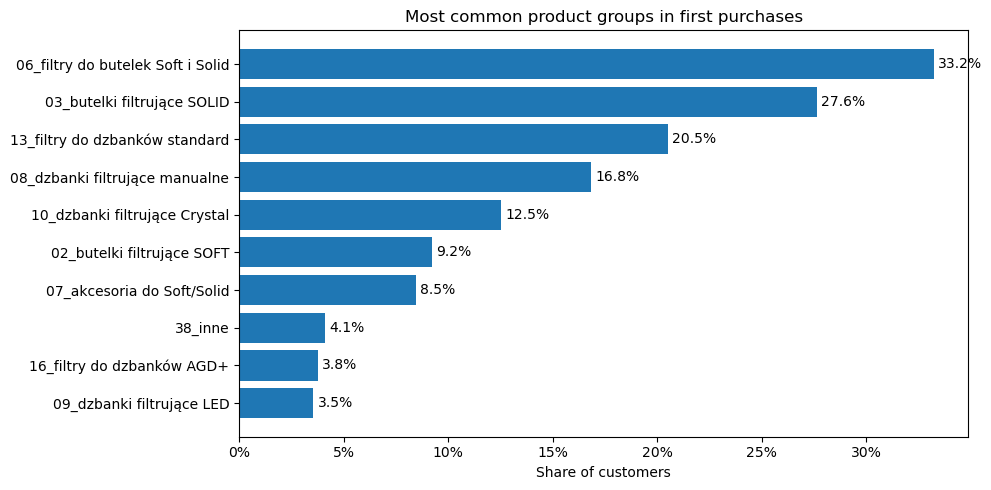

In [21]:
import matplotlib.pyplot as plt

# take top 10
top10 = entry_counts.head(10).copy()

plt.figure(figsize=(10, 5))
plt.barh(
    top10["product_group"][::-1],
    top10["pct_of_customers"][::-1]
)

plt.xlabel("Share of customers")
plt.title("Most common product groups in first purchases")

# format x-axis as %
plt.gca().xaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

# add value labels
for i, v in enumerate(top10["pct_of_customers"][::-1]):
    plt.text(v + 0.002, i, f"{v:.1%}", va="center")

plt.tight_layout()
plt.show()


## Entry products — returning customers only

In this view, we restrict the population to customers who made
**more than one purchase on different dates**.

Interpretation:
- This excludes one-time buyers
- Products shown here are more representative of
  true lifecycle entry products for retained customers

All other logic (first purchase date, counting all product groups
on that date) remains unchanged.


In [22]:
# count distinct purchase dates per customer
purchase_days = (
    df[df["is_purchase"]]
    .groupby("anon")["date"]
    .nunique()
    .rename("n_purchase_days")
)

# customers with more than 1 purchase
returning_customers = purchase_days[purchase_days > 1].index

# filter dataframe
df_ret = df[df["anon"].isin(returning_customers)].copy()

df_ret["anon"].nunique()


52157

In [24]:
# first purchase date per returning customer
first_date_ret = (
    df_ret.groupby("anon")["date"]
    .min()
    .rename("first_date")
)

df_ret = df_ret.merge(first_date_ret, on="anon", how="left")

entry_basket_ret = df_ret[df_ret["date"] == df_ret["first_date"]].copy()

entry_counts_ret = (
    entry_basket_ret["MATRIX GRUPA PRODUKTOWA"]
    .value_counts()
    .rename_axis("product_group")
    .reset_index(name="count")
)

entry_counts_ret["pct_of_customers"] = (
    entry_counts_ret["count"] / entry_basket_ret["anon"].nunique()
)

entry_counts_ret.head(20)


,product_group,count,pct_of_customers
0,06_filtry do butelek Soft i Solid,20272,0.388673
1,03_butelki filtrujące SOLID,17386,0.333340
2,13_filtry do dzbanków standard,10383,0.199072
3,10_dzbanki filtrujące Crystal,5901,0.113139
4,07_akcesoria do Soft/Solid,5278,0.101194
5,08_dzbanki filtrujące manualne,5080,0.097398
6,02_butelki filtrujące SOFT,4206,0.080641
7,38_inne,2774,0.053186
8,16_filtry do dzbanków AGD+,2733,0.052399
9,14_filtry do dzbanków Mg+,2113,0.040512


In [29]:
import matplotlib.pyplot as plt

def plot_top_product_groups(
    counts_df,
    title,
    top_n=10,
    pct_col="pct_of_customers",
    group_col="product_group",
    figsize=(10, 5),
    label_offset=0.002
):
    """
    Plot a horizontal bar chart of top product groups by share of customers.

    Parameters
    ----------
    counts_df : pd.DataFrame
        DataFrame with product group counts and percentages.
    title : str
        Plot title.
    top_n : int, default=10
        Number of top product groups to display.
    pct_col : str, default="pct_of_customers"
        Column containing percentage values (0–1).
    group_col : str, default="product_group"
        Column containing product group names.
    figsize : tuple, default=(10, 5)
        Figure size.
    label_offset : float, default=0.002
        Horizontal offset for value labels.
    """

    top = counts_df.head(top_n).copy()

    plt.figure(figsize=figsize)
    plt.barh(
        top[group_col][::-1],
        top[pct_col][::-1]
    )

    plt.xlabel("Share of customers")
    plt.title(title)

    # format x-axis as %
    plt.gca().xaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

    # add value labels
    for i, v in enumerate(top[pct_col][::-1]):
        plt.text(v + label_offset, i, f"{v:.1%}", va="center")

    plt.tight_layout()
    plt.show()


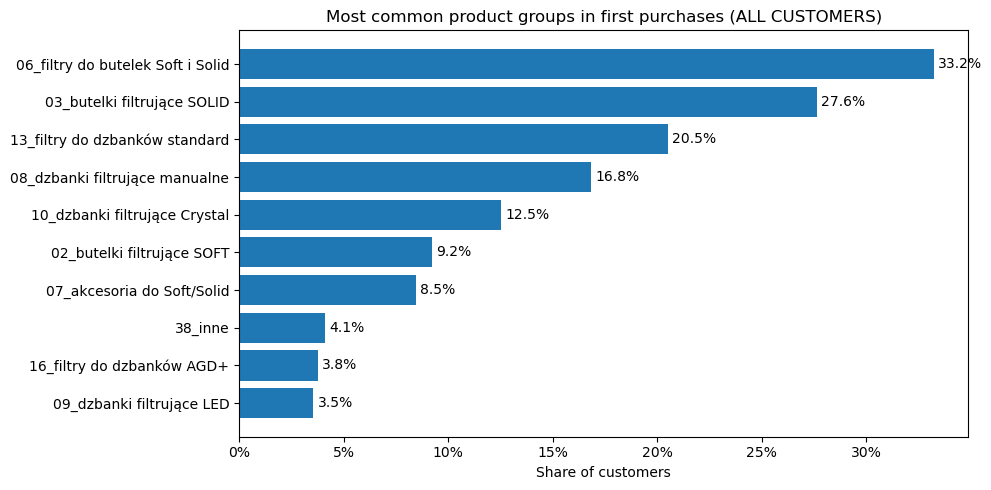

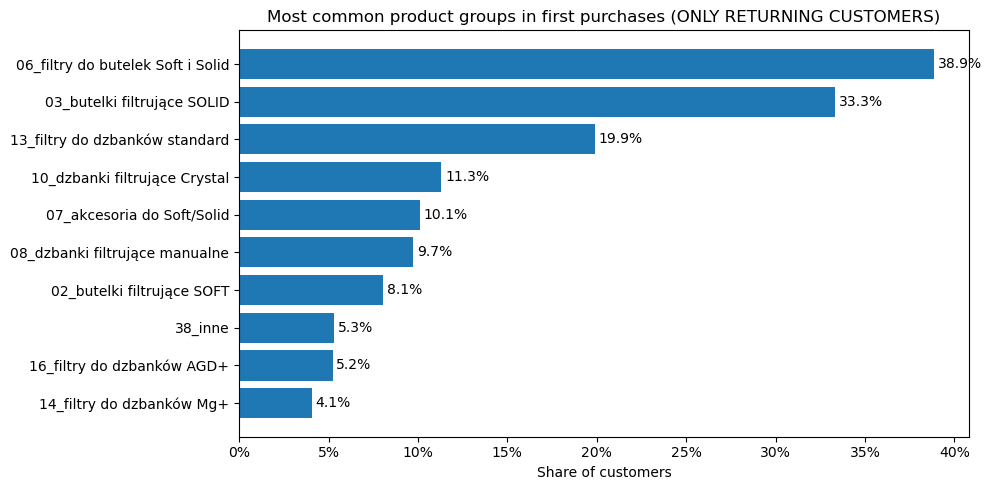

In [30]:
plot_top_product_groups(
    entry_counts,
    title="Most common product groups in first purchases (ALL CUSTOMERS)"
)

plot_top_product_groups(
    entry_counts_ret,
    title="Most common product groups in first purchases (ONLY RETURNING CUSTOMERS)"
)


In [28]:
# --------------------------------------------
# Most popular 2nd purchase products (returning customers)
# Reuses your existing df_ret + first_date logic
# --------------------------------------------

# 1) Second purchase date per returning customer
#    (earliest purchase date strictly AFTER the first purchase date)
second_date_ret = (
    df_ret[df_ret["date"] > df_ret["first_date"]]
    .groupby("anon")["date"]
    .min()
    .rename("second_date")
)

df_ret = df_ret.merge(second_date_ret, on="anon", how="left")

# 2) Basket on the 2nd purchase day
second_basket_ret = df_ret[df_ret["date"] == df_ret["second_date"]].copy()

# (optional sanity check)
print("Returning customers:", df_ret["anon"].nunique())
print("Customers with 2nd purchase day found:", second_basket_ret["anon"].nunique())

# 3) Count most common product groups in the 2nd purchase basket
second_counts_ret = (
    second_basket_ret["MATRIX GRUPA PRODUKTOWA"]
    .value_counts()
    .rename_axis("product_group")
    .reset_index(name="count")
)

second_counts_ret["pct_of_customers"] = (
    second_counts_ret["count"] / second_basket_ret["anon"].nunique()
)

second_counts_ret.head(20)


Returning customers: 52157
Customers with 2nd purchase day found: 52157


,product_group,count,pct_of_customers
0,06_filtry do butelek Soft i Solid,20471,0.392488
1,03_butelki filtrujące SOLID,13364,0.256226
2,13_filtry do dzbanków standard,10008,0.191882
3,07_akcesoria do Soft/Solid,7527,0.144314
4,10_dzbanki filtrujące Crystal,4327,0.082961
5,08_dzbanki filtrujące manualne,3882,0.074429
6,02_butelki filtrujące SOFT,3441,0.065974
7,16_filtry do dzbanków AGD+,3429,0.065744
8,14_filtry do dzbanków Mg+,2538,0.048661
9,38_inne,1871,0.035872


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_first_vs_second(
    first_df,
    second_df,
    title,
    top_n=10,
    pct_col="pct_of_customers",
    group_col="product_group",
    figsize=(12, 6),
    label_offset=0.002
):
    """
    Side-by-side comparison of first vs second purchase product groups
    using a shared x-axis, sorted descending (largest on top).
    """

    # take top N from FIRST purchase
    top_groups = (
        first_df
        .head(top_n)[group_col]
        .iloc[::-1]   # reverse order for descending display
    )

    f = (
        first_df
        .set_index(group_col)
        .loc[top_groups][pct_col]
    )
    s = (
        second_df
        .set_index(group_col)
        .reindex(top_groups)[pct_col]
        .fillna(0)
    )

    y = np.arange(len(top_groups))
    bar_h = 0.35

    plt.figure(figsize=figsize)

    plt.barh(y + bar_h / 2, f.values, height=bar_h, label="1st purchase")
    plt.barh(y - bar_h / 2, s.values, height=bar_h, label="2nd purchase")

    plt.yticks(y, top_groups)
    plt.xlabel("Share of customers")
    plt.title(title)
    plt.legend()

    # format x-axis as %
    plt.gca().xaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

    # value labels
    for i, v in enumerate(f.values):
        plt.text(v + label_offset, i + bar_h / 2, f"{v:.1%}", va="center")

    for i, v in enumerate(s.values):
        if v > 0:
            plt.text(v + label_offset, i - bar_h / 2, f"{v:.1%}", va="center")

    plt.tight_layout()
    plt.show()


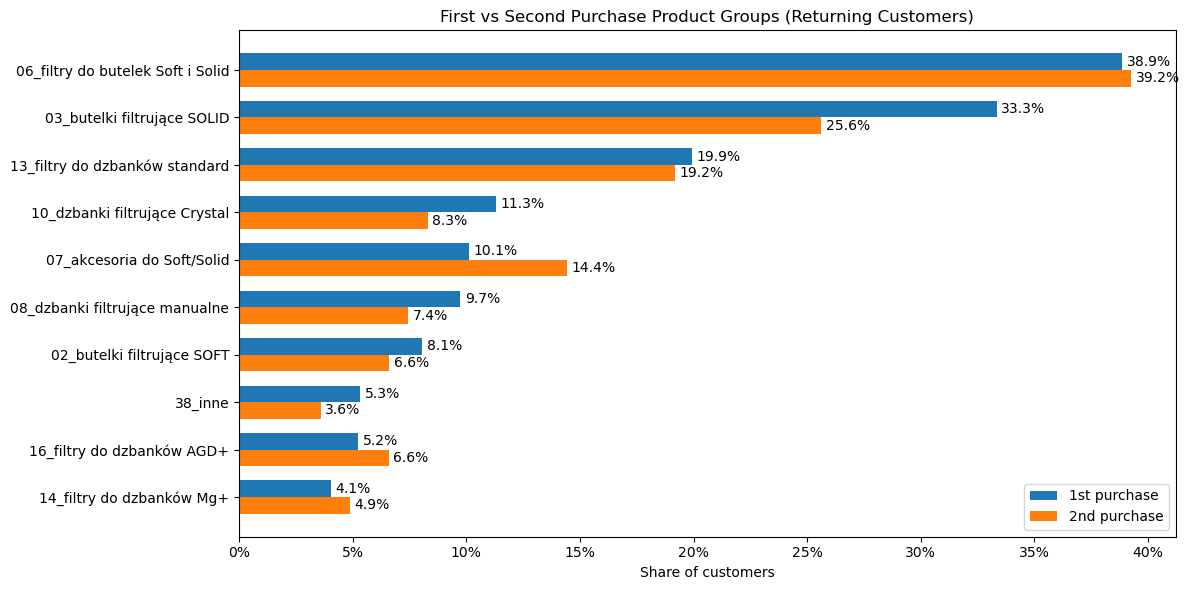

In [34]:
plot_first_vs_second(
    first_df=entry_counts_ret,
    second_df=second_counts_ret,
    title="First vs Second Purchase Product Groups (Returning Customers)"
)


In [35]:
entry_counts_ret.to_parquet("../data/interim/entry_counts_ret.parquet")
entry_counts.to_parquet("../data/interim/entry_counts.parquet")